In [1]:
import os
import pickle
import itertools
import datetime as dt
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from utils.scaler import STMatrixStandardScaler
from utils.helper import fix_seed, seed_worker, validate, multistep_validate
from dataset import STDataset
from trainer import Trainer
from logger import Logger
import config

In [2]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=2)

## データセットの定義

In [3]:
dt_table = pd.read_pickle(f'{config.TABLES_DIR}/datetime_table.pkl')
sec_table = pd.read_pickle(f'{config.TABLES_DIR}/section_table.pkl')

X_tr = torch.load(f'{config.DATASET_DIR}_1h/features_train_norm.pkl')
X_va = torch.load(f'{config.DATASET_DIR}_1h/features_test_norm.pkl')
y_tr = torch.load(f'{config.DATASET_DIR}_1h/labels_train.pkl')
y_va = torch.load(f'{config.DATASET_DIR}_1h/labels_test.pkl')

# X_tr = torch.load(f'datasets_1h/mini_features_train_norm.pkl')
# X_va = torch.load(f'datasets_1h/mini_features_test_norm.pkl')
# y_tr = torch.load(f'datasets_1h/mini_labels_train.pkl')
# y_va = torch.load(f'datasets_1h/mini_labels_test.pkl')

print(dt_table.shape, sec_table.shape)
print(X_tr.shape, X_va.shape)
print(y_tr.shape, y_va.shape)

(288, 1) (63, 4)
torch.Size([5, 7992, 63]) torch.Size([5, 2208, 63])
torch.Size([1, 7992, 63]) torch.Size([1, 2208, 63])


### LSTM only EncDec

In [5]:
class LSTMEncoder(nn.Module):
    def __init__(self, bidirectional=True):
        super().__init__()
        
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(1, TRAFFIC_HIDDEN, TRAFFIC_LSTM_LAYERS, bidirectional=bidirectional, dropout=0.4, batch_first=True)
    
    def forward(self, x):
        N, T, S = x.shape
        x = x[..., [S // 2]]
        # N x T x 1 -> N x T x H, (L x N x H, L x N x H)
        outs, (h, c) = self.lstm(x)
        
        if self.bidirectional:
            # 2*L_t x N x H_t -> L_t x N x 2*H_t
            L2, N, H_t = h.shape
            h = h.transpose(0,1).reshape(N, L2 // 2, -1).transpose(0,1).contiguous()
            c = h.transpose(0,1).reshape(N, L2 // 2, -1).transpose(0,1).contiguous()    
        
        return outs, (h, c)
    

class LSTMDecoder(nn.Module):
    def __init__(self, bidirectional=True):
        super().__init__()
        
        self.dropout_ratio = 0.3
        
        self.hid_dim = 2 * TRAFFIC_HIDDEN if bidirectional else TRAFFIC_HIDDEN
        
        self.bnorm = nn.BatchNorm1d(1)
        self.lstm = nn.LSTM(1, self.hid_dim, TRAFFIC_LSTM_LAYERS, dropout=self.dropout_ratio, batch_first=True)
        self.fc1 = nn.Linear(self.hid_dim, FC_EMB)
        self.fc2 = nn.Linear(FC_EMB, 1)

    def forward(self, x, state):
        N, _, P = x.shape
        # normalize
        x = self.bnorm(x)
        
        # N x C=1 x P -> N x P x C=1
        x = x.permute(0, 2, 1)
        # N x P x C, (L x N x H_t, L x N x H_t) -> N x P x H_t, (L x N x H_t, L x N x H_t)
        outs, state = self.lstm(x, state)
        outs = F.relu(self.fc1(outs))
        outs = self.fc2(outs)

        return outs, state
    
    def generate(self, trf_enc, start_value=-1.0):
        with torch.no_grad():
            # N x 1 x 1
            N = trf_enc[0].shape[1]
            out = torch.tensor(start_value).repeat(N).unsqueeze(-1).unsqueeze(-1)
            out = out.to(trf_enc[0].device)
            
            state = trf_enc
            
            generated = []

            for i in range(24):
                out, state = self.forward(out, state)
                generated.append(out)
        
        # N x P x 1
        generated = torch.cat(generated, dim=1)
        # N x P x 1 -> N x P
        generated = generated[..., 0]
        return generated
    

class LSTMOnlyEncoderDecoder(nn.Module):
    def __init__(self, bidirectional=True):
        super().__init__()
        
        self.encoder = LSTMEncoder(bidirectional=bidirectional)
        self.decoder = LSTMDecoder(bidirectional=bidirectional)
        
    def forward(self, features, decoder_xs):
        dt, rd, sr, un_sr, trf = features
        
        outs_trf, state_trf = self.encoder(trf)
        outs, _ = self.decoder(decoder_xs, state_trf)
        outs = outs[..., 0]
        return outs
    
    def generate(self, features, start_value=-1.0):
        dt, rd, sr, un_sr, trf = features
        
        outs_trf, state_trf = self.encoder(trf)    
        generated = self.decoder.generate(state_trf, start_value)
        return generated

### LSTM + CNN EncDec

In [6]:
class CNNLSTMEncoder(nn.Module):
    def __init__(self, bidirectional=True):
        super().__init__()
        
        self.bidirectional = bidirectional
        
        self.conv = nn.Conv2d(1, TRAFFIC_CONV, TRAFFIC_KERNEL, padding=(TRAFFIC_KERNEL[0]//2, 0), padding_mode='replicate')
        self.lstm = nn.LSTM(TRAFFIC_CONV, TRAFFIC_HIDDEN, TRAFFIC_LSTM_LAYERS, bidirectional=bidirectional, dropout=0.4, batch_first=True)
    
    def forward(self, x):
        N, T, S = x.shape
        
        out = F.relu(self.conv(x.unsqueeze(1)))
        # N x C x T -> N x T x C
        out = out[..., 0].permute(0, 2, 1)
        # N x T x C -> N x T x H, (L x N x H, L x N x H)
        outs, (h, c) = self.lstm(out)
        
        if self.bidirectional:
            # 2*L_t x N x H_t -> L_t x N x 2*H_t
            L2, N, H_t = h.shape
            h = h.transpose(0,1).reshape(N, L2 // 2, -1).transpose(0,1).contiguous()
            c = h.transpose(0,1).reshape(N, L2 // 2, -1).transpose(0,1).contiguous()
        
        return outs, (h, c)
    

class CNNLSTMEncoderDecoder(LSTMOnlyEncoderDecoder):
    def __init__(self, bidirectional=True):
        super().__init__()
        
        self.encoder = CNNLSTMEncoder(bidirectional=bidirectional)
        self.decoder = LSTMDecoder(bidirectional=bidirectional)

### LSTM + Embedding EncDec

In [7]:
class LSTMEmbeddingDecoder(nn.Module):
    def __init__(self, bidirectional=True):
        super().__init__()
        
        self.dropout_ratio = 0.3
        
        self.hid_dim = 2 * TRAFFIC_HIDDEN if bidirectional else TRAFFIC_HIDDEN
        
        self.datetime_embedding = CategoricalEmbedding(config.DT_TABLE_SIZE, DATETIME_EMB)
        self.road_embedding = CategoricalEmbedding(config.SEC_TABLE_SIZE, ROAD_EMB)
        self.emb_dropout = nn.Dropout(p=0.4)
        
        self.bnorm = nn.BatchNorm1d(1)
        self.lstm = nn.LSTM(1, self.hid_dim, TRAFFIC_LSTM_LAYERS, dropout=self.dropout_ratio, batch_first=True)
        self.fc1 = nn.Linear(self.hid_dim + DATETIME_EMB + ROAD_EMB, FC_EMB)
        self.fc2 = nn.Linear(FC_EMB, 1)

    def forward(self, x, state, dt, rd):
        N, _, P = x.shape
        # normalize
        x = self.bnorm(x)
        
        # N x C=1 x P -> N x P x C=1
        x = x.permute(0, 2, 1)
        # N x P x C, (L x N x H_t, L x N x H_t) -> N x P x H_t, (L x N x H_t, L x N x H_t)
        outs, state = self.lstm(x, state)
        
        # N x P -> N x P x H_d
        dt_emb = self.datetime_embedding(dt)
        dt_emb = self.emb_dropout(dt_emb)
        # N x 1 -> N x 1 x H_r
        rd_emb = self.road_embedding(rd)
        rd_emb = self.emb_dropout(rd_emb)
        
        outs = torch.cat([
            dt_emb, 
            rd_emb.repeat(1, P, 1), 
            outs
        ], dim=-1)
        
        outs = F.relu(self.fc1(outs))
        outs = self.fc2(outs)

        return outs, state
    
    def generate(self, trf_enc, dt, rd, start_value=-1.0):
        with torch.no_grad():
            # N x 1 x 1
            N = trf_enc[0].shape[1]
            out = torch.tensor(start_value).repeat(N).unsqueeze(-1).unsqueeze(-1)
            out = out.to(trf_enc[0].device)
            
            state = trf_enc
            
            generated = []

            for i in range(24):
                out, state = self.forward(out, state, dt[:, [i]], rd)
                generated.append(out)
        
        # N x P x 1
        generated = torch.cat(generated, dim=1)
        # N x P x 1 -> N x P
        generated = generated[..., 0]
        return generated
    

class LSTMEmbeddingEncoderDecoder(nn.Module):
    def __init__(self, bidirectional=True):
        super().__init__()
        
        self.encoder = LSTMEncoder(bidirectional=bidirectional)
        self.decoder = LSTMEmbeddingDecoder(bidirectional=bidirectional)
        
    def forward(self, features, decoder_xs):
        dt, rd, sr, un_sr, trf = features
        
        outs_trf, state_trf = self.encoder(trf)
        outs, _ = self.decoder(decoder_xs, state_trf, dt, rd)
        outs = outs[..., 0]
        return outs
    
    def generate(self, features, start_value=-1.0):
        dt, rd, sr, un_sr, trf = features
        
        outs_trf, state_trf = self.encoder(trf)    
        generated = self.decoder.generate(state_trf, dt, rd, start_value)
        return generated

### Encoder-Decoder

In [11]:
class TrafficSearchEncoder(nn.Module):
    def __init__(self, conv_dim, kernel, lstm_dim, lstm_layers, lstm_dropout, bidirectional=True):
        super().__init__()
        
        self.lstm_dropout = lstm_dropout
        self.bidirectional = bidirectional
        
        self.conv = nn.Conv2d(1, conv_dim, kernel, 
                              padding=(kernel[0]//2, 0), padding_mode='replicate')
        self.lstm = nn.LSTM(conv_dim, lstm_dim, lstm_layers, 
                            dropout=lstm_dropout, bidirectional=bidirectional, batch_first=True)
        
    def forward(self, x):
        N, T, S = x.shape
        
        out = F.relu(self.conv(x.unsqueeze(1)))
        # N x C x T -> N x T x C
        out = out[..., 0].permute(0, 2, 1)
        # N x T x C -> N x T x H, (L x N x H, L x N x H)
        outs, (h, c) = self.lstm(out)
        
        return outs, (h, c)

    
class SearchUnspecEncoder(nn.Module):
    def __init__(self, p_dropout):
        super().__init__()
        
        self.p_dropout = p_dropout
        
        self.conv = nn.Conv1d(1, UNSPEC_SEARCH_HIDDEN, UNSPEC_SEARCH_KERNEL, padding_mode='replicate')
        # self.dropout = nn.Dropout(p=0)
        self.dropout = nn.Dropout(p=p_dropout)
    
    def forward(self, x):
        N, T, S = x.shape
        out = F.relu(self.conv(x))
        # N x C x T -> N x T x C
        out = out.permute(0, 2, 1)
        out = self.dropout(out)
        
        return out

    
class Encoder(nn.Module):
    def __init__(
        self, lstm_dropout, unspec_search_dropout=0.4, include_search=True, bidirectional=True
    ):
        super().__init__()
        
        self.lstm_dropout = lstm_dropout
        self.unspec_search_dropout = unspec_search_dropout
        self.include_search = include_search
        self.bidirectional = bidirectional
        
        self.traffic_encoder = TrafficSearchEncoder(
            TRAFFIC_CONV, TRAFFIC_KERNEL, TRAFFIC_HIDDEN, TRAFFIC_LSTM_LAYERS,
            lstm_dropout=lstm_dropout, bidirectional=bidirectional
        )
        
        if include_search:
            self.search_encoder = TrafficSearchEncoder(
                SEARCH_CONV, SEARCH_KERNEL, SEARCH_HIDDEN, SEARCH_LSTM_LAYERS,
                lstm_dropout=lstm_dropout, bidirectional=bidirectional
            )
            self.unspec_search_encoder = SearchUnspecEncoder(p_dropout=unspec_search_dropout)
        
    def forward(self, x_trf, x_sr, x_un_sr):
        # N x T x S -> N x T x H_t, (bi*L_t x N x H_t, bi*L_t x N x H_t)
        outs_trf, state_trf = self.traffic_encoder(x_trf)
        if self.bidirectional:
            # 2*L_t x N x H_t -> L_t x N x 2*H_t
            L2, N, H_t = state_trf[0].shape
            h = state_trf[0].transpose(0,1).reshape(N, L2 // 2, -1).transpose(0,1).contiguous()
            c = state_trf[1].transpose(0,1).reshape(N, L2 // 2, -1).transpose(0,1).contiguous()
            state_trf = (h, c)
        
        if self.include_search:
            # N x P x S -> N x P x H_s, (L_s x N x H_s, L_s x N x H_s) 
            outs_sr, state_sr = self.search_encoder(x_sr)
            # N x 1 x S -> N x 1 x H_u
            out_un_sr = self.unspec_search_encoder(x_un_sr)
            return (outs_trf, state_trf), outs_sr, out_un_sr
        return outs_trf, state_trf

In [12]:
class CategoricalEmbedding(nn.Module):
    def __init__(self, category_size, emb_size):
        super().__init__()

        self.category_size = category_size
        self.emb_size = emb_size
        self.embedding = nn.Embedding(category_size, emb_size)

    def forward(self, x):
        out = self.embedding(x.to(dtype=torch.int64))
        return out

class TrafficDecoder(nn.Module):
    def __init__(self, lstm_dropout, bidirectional=True):
        super().__init__()
        
        self.lstm_dropout = lstm_dropout
        
        self.hid_dim = 2 * TRAFFIC_HIDDEN if bidirectional else TRAFFIC_HIDDEN
        
        self.bnorm = nn.BatchNorm1d(1)
        self.lstm = nn.LSTM(1, self.hid_dim, TRAFFIC_LSTM_LAYERS, 
                            dropout=lstm_dropout, batch_first=True)

    def forward(self, x, state):
        N, _, P = x.shape
        # normalize
        x = self.bnorm(x)
        
        # N x C=1 x P -> N x P x C=1
        x = x.permute(0, 2, 1)
        # N x P x C, (L x N x H_t, L x N x H_t) -> N x P x H_t, (L x N x H_t, L x N x H_t)
        outs, state = self.lstm(x, state)
        return outs, state

class AffineDecoder(nn.Module):
    def __init__(self, embedding_dropout, include_search=True, bidirectional=True):
        super().__init__()
        
        self.embedding_dropout = embedding_dropout
        self.include_search = include_search
        self.bidirectional = bidirectional
        
        if include_search:
            if bidirectional:
                self.n_dim = 2*TRAFFIC_HIDDEN + 2*SEARCH_HIDDEN + UNSPEC_SEARCH_HIDDEN + DATETIME_EMB + ROAD_EMB
            else:
                self.n_dim = TRAFFIC_HIDDEN + SEARCH_HIDDEN + UNSPEC_SEARCH_HIDDEN + DATETIME_EMB + ROAD_EMB
        else:
            if bidirectional:
                self.n_dim = 2*TRAFFIC_HIDDEN + DATETIME_EMB + ROAD_EMB
            else:
                self.n_dim = TRAFFIC_HIDDEN + DATETIME_EMB + ROAD_EMB
        
        self.datetime_embedding = CategoricalEmbedding(config.DT_TABLE_SIZE, DATETIME_EMB)
        self.road_embedding = CategoricalEmbedding(config.SEC_TABLE_SIZE, ROAD_EMB)
        self.emb_dropout = nn.Dropout(p=embedding_dropout)
        
        self.fc1 = nn.Linear(self.n_dim, FC_EMB)
        self.fc2 = nn.Linear(FC_EMB, 1)
        
    def forward(self, trf_dec, sr_enc, un_sr_enc, dt, rd):
        # traffic_dec: N x P x H_t
        N, P, H_t = trf_dec.shape
        
        # N x P -> N x P x H_d
        dt_emb = self.datetime_embedding(dt)
        dt_emb = self.emb_dropout(dt_emb)
        # N x 1 -> N x 1 x H_r
        rd_emb = self.road_embedding(rd)
        rd_emb = self.emb_dropout(rd_emb)
        
        if self.include_search:
            outs = torch.cat([
                dt_emb, 
                rd_emb.repeat(1, P, 1), 
                sr_enc, 
                un_sr_enc.repeat(1, P, 1),
                trf_dec
            ], dim=-1)
        else:
            outs = torch.cat([
                dt_emb, 
                rd_emb.repeat(1, P, 1), 
                trf_dec
            ], dim=-1)
        # N x P x SUM -> N x P x H_fc
        outs = F.relu(self.fc1(outs))
        # N x P x H_fc -> N x P x 1
        outs = self.fc2(outs)
        
        return outs

class Decoder(nn.Module):
    def __init__(self, lstm_dropout, embedding_dropout=0.4, include_search=True, bidirectional=True):
        super().__init__()
        
        self.lstm_dropout = lstm_dropout
        self.embedding_dropout = embedding_dropout
        self.include_search = include_search
        
        self.traffic_decoder = TrafficDecoder(lstm_dropout=lstm_dropout, bidirectional=bidirectional)
        self.affine_decoder = AffineDecoder(
            embedding_dropout=embedding_dropout, include_search=include_search, 
            bidirectional=bidirectional
        )
    
    def forward(self, x, trf_enc, sr_enc, un_sr_enc, dt, rd):
        # N x 1 x P, (L x N x H_t, L x N x H_t) -> N x P x H_t, (L x N x H_t, L x N x H_t)
        outs_trf, state_trf = self.traffic_decoder(x, trf_enc)
        outs = self.affine_decoder(outs_trf, sr_enc, un_sr_enc, dt, rd)
        # N x P x 1 -> N x P
        outs = outs[..., 0]
        return outs
    
    def generate(self, trf_enc, sr_enc, un_sr_enc, dt, rd, start_value=-1.0):
        with torch.no_grad():
            # N x 1 x 1
            N = trf_enc[0].shape[1]
            out = torch.tensor(start_value).repeat(N).unsqueeze(-1).unsqueeze(-1)
            out = out.to(trf_enc[0].device)
            
            state = trf_enc
            
            generated = []

            for i in range(PREDICTION_HORIZON):
                out, state = self.traffic_decoder(out, state)
                if self.include_search:
                    out = self.affine_decoder(out, sr_enc[:, [i]], un_sr_enc, dt[:, [i]], rd)
                else:
                    out = self.affine_decoder(out, None, None, dt[:, [i]], rd)

                generated.append(out)
        
        # N x P x 1
        generated = torch.cat(generated, dim=1)
        # N x P x 1 -> N x P
        generated = generated[..., 0]
        return generated

In [13]:
class EncoderDecoder(nn.Module):
    def __init__(self, lstm_dropout=0, include_search=True, bidirectional=True):
        super().__init__()
        
        self.lstm_dropout = lstm_dropout
        self.include_search = include_search
        
        self.encoder = Encoder(
            lstm_dropout=lstm_dropout, include_search=include_search, bidirectional=bidirectional
        )
        self.decoder = Decoder(
            lstm_dropout=lstm_dropout, include_search=include_search, bidirectional=bidirectional
        )
        
    def forward(self, features, decoder_xs):
        dt, rd, sr, un_sr, trf = features
        
        if self.include_search:
            (outs_trf, state_trf), outs_sr, outs_un_sr = self.encoder(trf, sr, un_sr)
        else:
            outs_trf, state_trf = self.encoder(trf, sr, un_sr)
            outs_sr, outs_un_sr = None, None
            
        outs = self.decoder(decoder_xs, state_trf, outs_sr, outs_un_sr, dt, rd)

        return outs
    
    def generate(self, features, start_value=-1.0):
        dt, rd, sr, un_sr, trf = features
        
        if self.include_search:
            (outs_trf, state_trf), outs_sr, outs_un_sr = self.encoder(trf, sr, un_sr)
        else:
            outs_trf, state_trf = self.encoder(trf, sr, un_sr)
            outs_sr, outs_un_sr = None, None
        
        generated = self.decoder.generate(state_trf, outs_sr, outs_un_sr, dt, rd, start_value)
        return generated

## 学習

In [10]:
def get_dataset(X_tr, y_tr, X_va, y_va, time_step=7*24, space_window=(-2,2)):
    dataset_train = STDataset(X_tr, y_tr, time_step=time_step, space_window=space_window)
    dataset_valid = STDataset(X_va, y_va, time_step=time_step, space_window=space_window)
    
    return dataset_train, dataset_valid

def get_loader(dataset, batch_size=config.BATCH_SIZE, shuffle=False):
    g = torch.Generator()
    g.manual_seed(config.RANDOM_SEED)

    dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=shuffle, worker_init_fn=seed_worker, generator=g)
    return dataloader


def train(n_epochs, dataset_train, dataset_valid, model, 
          model_name=None, log_path=None, random_state=config.RANDOM_SEED):
    fix_seed(random_state)
    
    train_loader = get_loader(dataset_train, shuffle=True)
    val_loader = get_loader(dataset_valid, shuffle=False)
    
    # model
    model = model.to(device)
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.L1Loss()

    logger = Logger(fname=log_path)
    trainer = Trainer(model, optimizer, loss_fn, device=device, logger=logger, model_name=model_name)
    
    train_losses, val_losses = \
        trainer.fit(train_loader, val_loader, n_epochs, log_steps=1)

    return trainer


def predict(model, dataset, device=device):
    model.eval()

    with torch.no_grad():
        data, _ = dataset[:]
        if isinstance(data, (list, tuple)):
            data = map(lambda x: x.to(device=device), data)
        else:
            data = data.to(device=device)
        out = model.generate(data).detach().cpu()

    return out

## Networkの定義

In [8]:
TRAFFIC_CONV = 64
TRAFFIC_HIDDEN = 128
TRAFFIC_LSTM_LAYERS = 4
# TRAFFIC_KERNEL = (7,5)

SEARCH_CONV = 64
SEARCH_HIDDEN = 128
SEARCH_LSTM_LAYERS = 4
# SEARCH_KERNEL = (7,5)

UNSPEC_SEARCH_HIDDEN = 64
# UNSPEC_SEARCH_KERNEL = 5

DATETIME_EMB = 32
ROAD_EMB = 16

FC_EMB = 32

PREDICTION_HORIZON = 24

## Traffic, Searchのカーネルサイズを変える
s.t. TRAFFIC_KERNEL = SEARCH_KERNEL

In [17]:
# class TrafficSearchEncoder(nn.Module):
#     def __init__(self, conv_dim, kernel, lstm_dim, lstm_layers, bidirectional=True):
#         super().__init__()
        
#         self.bidirectional = bidirectional
        
#         self.n_conv = kernel[1] // 2
#         self.kernel_size = (kernel[0], 3)
#         self.padding = (kernel[0] // 2, 0)
#         self.conv_first = nn.Conv2d(1, conv_dim, self.kernel_size, padding=self.padding, padding_mode='replicate')
#         self.conv_layers = nn.ModuleList(
#             [nn.Conv2d(conv_dim, conv_dim, self.kernel_size, padding=self.padding, padding_mode='replicate') for _ in range(self.n_conv-1)]
#         )
        
#         # self.lstm = nn.LSTM(conv_dim, lstm_dim, lstm_layers, bidirectional=bidirectional, batch_first=True)
#         self.lstm = nn.LSTM(conv_dim, lstm_dim, lstm_layers, bidirectional=bidirectional, dropout=0.4, batch_first=True)
        
    
#     def forward(self, x):
#         N, T, S = x.shape
        
#         out = F.relu(self.conv_first(x.unsqueeze(1)))
#         for conv in self.conv_layers:
#             out = F.relu(conv(out))
#         # N x C x T -> N x T x C
#         out = out[..., 0].permute(0, 2, 1)
#         # N x T x C -> N x T x H, (L x N x H, L x N x H)
#         outs, (h, c) = self.lstm(out)
        
#         return outs, (h, c)

In [9]:
kernel_time = [3, 5, 7, 9, 11, 13]
kernel_space = [3, 5, 7]
kernel_cand = list(itertools.product(kernel_time, kernel_space))

In [14]:
n_epochs = 100
random_seed = 1000

trainer_list = []

for kernel in kernel_cand:
    model_name = f'kernels/STE-ED-S_kernel{kernel[0]}-{kernel[1]}_RS{random_seed}'
    log_path = f'./logs/{model_name}.log'
    # model_name, log_path = None, None
    
    print('='*30, f'Kernel Size: {kernel}', '='*30)
    TRAFFIC_KERNEL = SEARCH_KERNEL = kernel
    UNSPEC_SEARCH_KERNEL = kernel[-1]
    
    space_window = (-kernel[-1]//2+1, kernel[-1]//2)
    dataset_train, dataset_valid = get_dataset(X_tr, y_tr, X_va, y_va, space_window=space_window)
    
    model = EncoderDecoder(lstm_dropout=0)
    trainer = train(n_epochs, dataset_train, dataset_valid, model,
                    model_name, log_path, random_state=random_seed)
    
    print('='*30, f'(Kernel Size = {kernel}) best loss: {min(trainer.val_losses):.3f}', '='*30)
    trainer_list.append(trainer)

============================== Kernel Size: (3, 3) ==============================
2022-09-29 17:22:47.016609 | Epoch: 1 | Train Loss: 880.972, Train Time: 6.37 [sec] | Valid Loss: 853.041, Valid Time: 0.89 [sec]
2022-09-29 17:22:52.149555 | Epoch: 2 | Train Loss: 718.703, Train Time: 4.21 [sec] | Valid Loss: 710.991, Valid Time: 0.89 [sec]
2022-09-29 17:22:57.305357 | Epoch: 3 | Train Loss: 643.428, Train Time: 4.22 [sec] | Valid Loss: 650.340, Valid Time: 0.89 [sec]
2022-09-29 17:23:02.611529 | Epoch: 4 | Train Loss: 528.941, Train Time: 4.37 [sec] | Valid Loss: 449.807, Valid Time: 0.90 [sec]
2022-09-29 17:23:07.825742 | Epoch: 5 | Train Loss: 336.975, Train Time: 4.28 [sec] | Valid Loss: 299.451, Valid Time: 0.90 [sec]
2022-09-29 17:23:13.059441 | Epoch: 6 | Train Loss: 241.669, Train Time: 4.30 [sec] | Valid Loss: 239.678, Valid Time: 0.90 [sec]
2022-09-29 17:23:18.306305 | Epoch: 7 | Train Loss: 189.016, Train Time: 4.31 [sec] | Valid Loss: 207.657, Valid Time: 0.90 [sec]
2022-09-

In [15]:
for kernel, trainer in zip(kernel_cand, trainer_list):
    print(f'Kernel: {kernel}\t| Loss: {min(trainer.val_losses):.3f}')

Kernel: (3, 3)	| Loss: 102.210
Kernel: (3, 5)	| Loss: 101.615
Kernel: (3, 7)	| Loss: 106.164
Kernel: (5, 3)	| Loss: 101.914
Kernel: (5, 5)	| Loss: 105.067
Kernel: (5, 7)	| Loss: 104.956
Kernel: (7, 3)	| Loss: 105.152
Kernel: (7, 5)	| Loss: 101.173
Kernel: (7, 7)	| Loss: 104.195
Kernel: (9, 3)	| Loss: 102.777
Kernel: (9, 5)	| Loss: 102.364
Kernel: (9, 7)	| Loss: 103.547
Kernel: (11, 3)	| Loss: 104.035
Kernel: (11, 5)	| Loss: 102.617
Kernel: (11, 7)	| Loss: 102.072
Kernel: (13, 3)	| Loss: 103.684
Kernel: (13, 5)	| Loss: 102.648
Kernel: (13, 7)	| Loss: 105.431


### save

In [17]:
y_test = dataset_valid[:][1][:,0]
random_seed = 1000

kernels_result = {kernel: {} for kernel in kernel_cand}

for kernel in kernel_cand:
    TRAFFIC_KERNEL = SEARCH_KERNEL = kernel
    UNSPEC_SEARCH_KERNEL = kernel[-1]
    model = EncoderDecoder(lstm_dropout=0).to(device=device)
    
    model_path = f'{config.MODEL_DIR}/kernels/STE-ED-S_kernel{kernel[0]}-{kernel[1]}_RS{random_seed}_best.pth'
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    space_window = (-kernel[-1]//2+1, kernel[-1]//2)
    _, dataset_valid = get_dataset(X_tr, y_tr, X_va, y_va, space_window=space_window)
    
    fix_seed(random_seed)
    
    pred_test = predict(model, dataset_valid)
    mae, rmse = validate(pred_test, y_test)
    
    mae_steps = np.abs(pred_test - y_test).mean(axis=0)
    rmse_steps = ((pred_test - y_test)**2).mean(axis=0)
    
    kernels_result[kernel]['path'] = model_path
    kernels_result[kernel]['pred_test'] = pred_test
    kernels_result[kernel]['test_mae'] = mae
    kernels_result[kernel]['test_rmse'] = rmse
    kernels_result[kernel]['test_mae_steps'] = mae_steps
    kernels_result[kernel]['test_rmse_steps'] = rmse_steps

In [19]:
with open("./results/STE-ED-S_kernels_result.pkl", "wb") as f:
    pickle.dump(kernels_result, f)

## 評価

In [20]:
with open("results/STE-ED-S_kernels_result.pkl", "rb") as f:
    kernels_result = pickle.load(f)

In [21]:
kernel_time = [3, 5, 7, 9, 11, 13]
kernel_space = [3, 5, 7]
kernel_cand = list(itertools.product(kernel_time, kernel_space))

In [22]:
mae_heatmap = np.empty((len(kernel_time), len(kernel_space)), dtype=np.float32)
rmse_heatmap = np.empty((len(kernel_time), len(kernel_space)), dtype=np.float32)

for i, (kernel, result) in enumerate(kernels_result.items()):
    print(f'Kernel: {kernel}, MAE = {result["test_mae"]:.3f}, RMSE = {result["test_rmse"]:.3f}')
    
    mae_heatmap[i // len(kernel_space), i % len(kernel_space)] = result['test_mae']
    rmse_heatmap[i // len(kernel_space), i % len(kernel_space)] = result['test_rmse']
    
min_mae_kernel = min(kernels_result.items(), key=lambda kv: kv[1]['test_mae'].item())
print(f'Min MAE = {min_mae_kernel[1]["test_mae"]:.3f} (Kernel = {min_mae_kernel[0]})')
min_rmse_kernel = min(kernels_result.items(), key=lambda kv: kv[1]['test_rmse'].item())
print(f'Min RMSE = {min_rmse_kernel[1]["test_rmse"]:.3f} (Kernel = {min_rmse_kernel[0]})')

Kernel: (3, 3), MAE = 102.489, RMSE = 200.940
Kernel: (3, 5), MAE = 101.886, RMSE = 196.952
Kernel: (3, 7), MAE = 106.450, RMSE = 207.006
Kernel: (5, 3), MAE = 102.174, RMSE = 197.533
Kernel: (5, 5), MAE = 105.332, RMSE = 200.614
Kernel: (5, 7), MAE = 105.236, RMSE = 203.807
Kernel: (7, 3), MAE = 105.431, RMSE = 206.237
Kernel: (7, 5), MAE = 101.435, RMSE = 195.360
Kernel: (7, 7), MAE = 104.462, RMSE = 202.762
Kernel: (9, 3), MAE = 103.045, RMSE = 203.920
Kernel: (9, 5), MAE = 102.627, RMSE = 198.407
Kernel: (9, 7), MAE = 103.818, RMSE = 200.590
Kernel: (11, 3), MAE = 104.322, RMSE = 202.818
Kernel: (11, 5), MAE = 102.879, RMSE = 198.699
Kernel: (11, 7), MAE = 102.312, RMSE = 194.928
Kernel: (13, 3), MAE = 103.964, RMSE = 203.473
Kernel: (13, 5), MAE = 102.921, RMSE = 200.351
Kernel: (13, 7), MAE = 105.704, RMSE = 204.787
Min MAE = 101.435 (Kernel = (7, 5))
Min RMSE = 194.928 (Kernel = (11, 7))


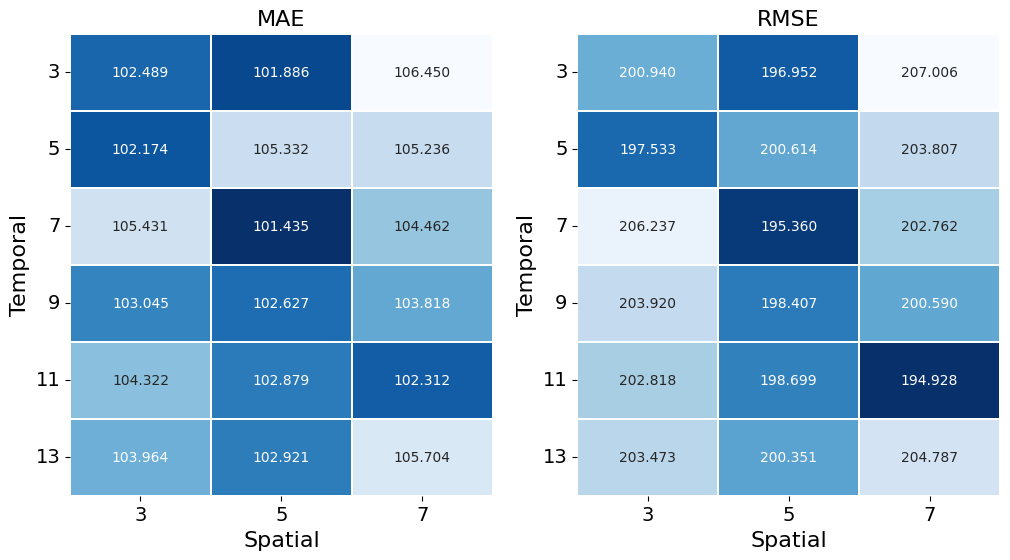

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(mae_heatmap, cmap='Blues_r', linewidths=0.2,
            annot=True, fmt='.3f', cbar=False,
            xticklabels=kernel_space, yticklabels=kernel_time, ax=axes[0])
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelrotation=0, labelsize=14)
axes[0].set_xlabel('Spatial', fontsize=16)
axes[0].set_ylabel('Temporal', fontsize=16)
axes[0].set_title('MAE', fontsize=16)

sns.heatmap(rmse_heatmap, cmap='Blues_r', linewidths=0.2, 
            annot=True, fmt='.3f', cbar=False,
            xticklabels=kernel_space, yticklabels=kernel_time, ax=axes[1])
axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelrotation=0, labelsize=14)
axes[1].set_xlabel('Spatial', fontsize=16)
axes[1].set_ylabel('Temporal', fontsize=16)
axes[1].set_title('RMSE', fontsize=16)

# plt.savefig('../figs/kernel_heatmap2.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

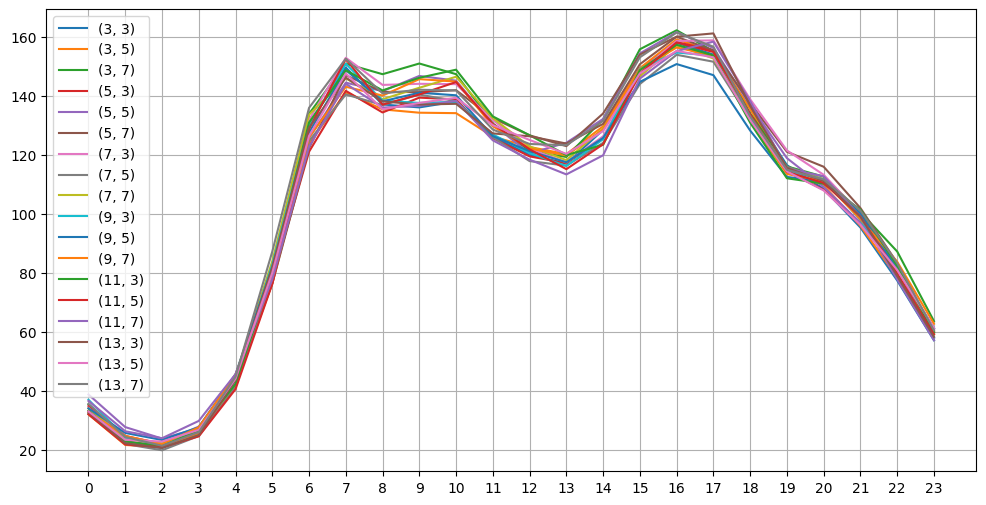

In [24]:
ticks = range(24)
labels = ticks

# markers = ['x', '^', 's', 'D', 'o']
# linestyles = ['--', ':', '--', '-.', '-']
# linewidths = [1.3,1.3,1.3,1.3,2]
# colors = ['darkturquoise', 'tab:orange', 'limegreen', 'royalblue', 'orangered']
# labels = ['T-ED', 'ST-ED', 'TE-ED', 'STE-ED', 'STE-ED-S']

fig, ax = plt.subplots(figsize=(12,6))
for kernel, result in kernels_result.items():
    ax.plot(result['test_mae_steps'], label=kernel)
    
ax.set_xticks(ticks=ticks)
# ax.tick_params(axis='x', labelsize=16)
# ax.tick_params(axis='y', labelsize=16)
# ax.set_xlabel('time steps', fontsize=18)
# ax.set_ylabel('Mean Absolute Error', fontsize=18)
ax.grid()
# ax.legend(fontsize=16)
ax.legend()

# plt.savefig('../figs/mae_time_steps.png', bbox_inches='tight', pad_inches=0.1)
plt.show()